In [14]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import sympy
sympy.init_printing()

from IPython.display import display

import numpy

import sys
sys.path.insert(0, './code')

from gauss_legendre import gauss_legendre, eval_expr
from evaluate_functional import evaluate_functional

### symbolic state vector

In [40]:
q = sympy.Symbol('q')
p = sympy.Symbol('p')
S_1 = sympy.Symbol('S_1')
S_2 = sympy.Symbol('S_2')

x = [q, p, S_1, S_2]
x

### parameters

In [16]:
h = sympy.Symbol('h')
k_B = sympy.Symbol('k_B')
N_A = sympy.Symbol('N_A')

l = sympy.Symbol('l')
r = sympy.Symbol('r')
w = sympy.Symbol('w')
A = sympy.Symbol('A')

ρ_Al = sympy.Symbol('rho_Al')
ρ_Cu = sympy.Symbol('rho_Cu')
m = sympy.Symbol('m')

κ_Al = sympy.Symbol('kappa_Al')
κ_Cu = sympy.Symbol('kappa_Cu')
α = sympy.Symbol('alpha')

m_Ar = sympy.Symbol('m_Ar')

C1 = sympy.Symbol('C1')
C2 = sympy.Symbol('C2')

N_1 = sympy.Symbol('N_1')
N_2 = sympy.Symbol('N_2')

params = {
    # Planck constant (Js)
    h: 6.62607015e-34,
    
    # Boltzmann constant (J/K)
    k_B: 1.380649e-23,
    
    # Avogadro constant (1/mol)
    N_A: 6.02214076 * 10**23,
    
    # length of cylinder (m)
    l: 0.1,
    
    # radius of cylinder / piston (m)
    r: 0.05,

    # length of piston (m)
    w: 0.006,
    
    # cross-sectional area of piston (m**2) 
    A: r**2 * sympy.pi,

    # density of piston material (kg/m**3)
    ρ_Al: 2700.0,
    ρ_Cu: 8960.0,
    
    # mass of piston (kg)
    m: ρ_Cu * A * w,

    # thermal conductivity piston material (W/(m*K))
    κ_Al: 237.0,
    κ_Cu: 401.0,
    
    # thermal conduction coefficient through piston (W/K)
    α: κ_Cu * A / w,
    
    # weight of one Argon atom (kg)
    m_Ar: 39.88 / (1000 * N_A),
    
    # constants to simplify constitutive equations of ideal gas
    C1: sympy.Rational(5,2) + sympy.Rational(3,2) * sympy.log((4 * sympy.pi * m_Ar) / (3 * h**2)),
    C2: h**2 / (2 * sympy.pi * sympy.exp(sympy.Rational(5,3)) * m_Ar),
}

### functionals

In [17]:
V_1 = sympy.Symbol('V_1')
V_2 = sympy.Symbol('V_2')

p_1 = sympy.Symbol('p_1')
p_2 = sympy.Symbol('p_2')

T_1 = sympy.Symbol('T_1')
T_2 = sympy.Symbol('T_2')

U_1 = sympy.Symbol('U_1')
U_2 = sympy.Symbol('U_2')

E = sympy.Symbol('E')

functionals = {
    # volume of each compartment (m**3)
    V_1: A * (q - (w/2)),
    V_2: A * (l - (q + w/2)),
    
    # pressure in each compartment (Pa)
    p_1: C2 * (N_1 / V_1) * (N_1 * sympy.exp(S_1 / (N_1 * k_B)) / V_1)**sympy.Rational(2,3),
    p_2: C2 * (N_2 / V_2) * (N_2 * sympy.exp(S_2 / (N_2 * k_B)) / V_2)**sympy.Rational(2,3),
    
    # temperature in each compartment (K)
    T_1: (C2 / k_B) * (N_1 * sympy.exp(S_1 / (N_1 * k_B)) / V_1)**sympy.Rational(2,3),
    T_2: (C2 / k_B) * (N_2 * sympy.exp(S_2 / (N_2 * k_B)) / V_2)**sympy.Rational(2,3),
    
    # internal energy in each compartment (J)
    U_1: N_1 * ((N_1 / V_1) * sympy.exp(S_1 / (k_B * N_1) - C1))**sympy.Rational(2,3),
    U_2: N_2 * ((N_2 / V_2) * sympy.exp(S_2 / (k_B * N_2) - C1))**sympy.Rational(2,3),

    # total energy of the system (J)
    E: sympy.Rational(1,2) * p**2 / m + U_1 + U_2,
}

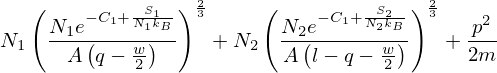

In [18]:
eval_expr(E, functionals)

### initial conditions

determine $N_1$, $N_2$ and $S_1(0)$, $S_2(0)$

In [19]:
# wanted conditions
q0 = params[l]/2

V_10 = float(eval_expr(V_1, functionals, params, {q: q0}))
V_20 = float(eval_expr(V_2, functionals, params, {q: q0}))

T_10 = 273.15 + 25.0
p_10 = 1.5 * 1e5

T_20 = 273.15 + 20.0
p_20 = 1.0 * 1e5

In [20]:
import ideal_gas
from scipy.optimize import fsolve

In [21]:
N_10 = fsolve(lambda N : ideal_gas.S_p(ideal_gas.U2(T_10, N), V_10, N) - p_10, x0=2e22)[0]
S_10 = ideal_gas.S(ideal_gas.U2(T_10, N_10), V_10, N_10)
print(f"N = {N_10}")
print(f"S = {S_10}")
print(f"T = {ideal_gas.U_T(S_10, V_10, N_10) - 273.15}°C")
print(f"p = {ideal_gas.U_p(S_10, V_10, N_10) * 1e-5} bar")
print(f"U = {ideal_gas.U(S_10, V_10, N_10)}")

N = 1.345119603317771e+22
S = 3.3828942208847232
T = 25.00000000000159°C
p = 1.500000000000008 bar
U = 83.05585577928


In [22]:
N_20 = fsolve(lambda N : ideal_gas.S_p(ideal_gas.U2(T_20, N), V_20, N) - p_20, x0=2e22)[0]
S_20 = ideal_gas.S(ideal_gas.U2(T_20, N_20), V_20, N_20)
print(f"N = {N_20}")
print(f"S = {S_20}")
print(f"T = {ideal_gas.U_T(S_20, V_20, N_20) - 273.15}°C")
print(f"p = {ideal_gas.U_p(S_20, V_20, N_20) * 1e-5} bar")
print(f"U = {ideal_gas.U(S_20, V_20, N_20)}")

N = 9.12041411630436e+21
S = 2.3394613409617664
T = 20.000000000004206°C
p = 1.0000000000000147 bar
U = 55.37057051952051


In [23]:
x_0 = [q0, 0, S_10, S_20]
params[N_1] = N_10
params[N_2] = N_20

### dynamics

In [24]:
x

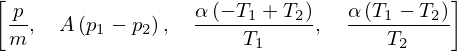

In [25]:
F = [p / m, A * (p_1 - p_2), α*(T_2 - T_1)/T_1, α*(T_1-T_2)/T_2]
F

In [48]:
t_f = 0.8
dt = 1e-4
s = 2
print(f"K = {int(t_f // dt)}")

K = 8000


In [49]:
%time time, solution = gauss_legendre(x, F, x_0, t_f, dt, s, functionals, params)

CPU times: user 6.1 s, sys: 19.5 ms, total: 6.12 s
Wall time: 6.12 s


In [28]:
tim, sol = numpy.array(time), numpy.array(solution[:, 0])

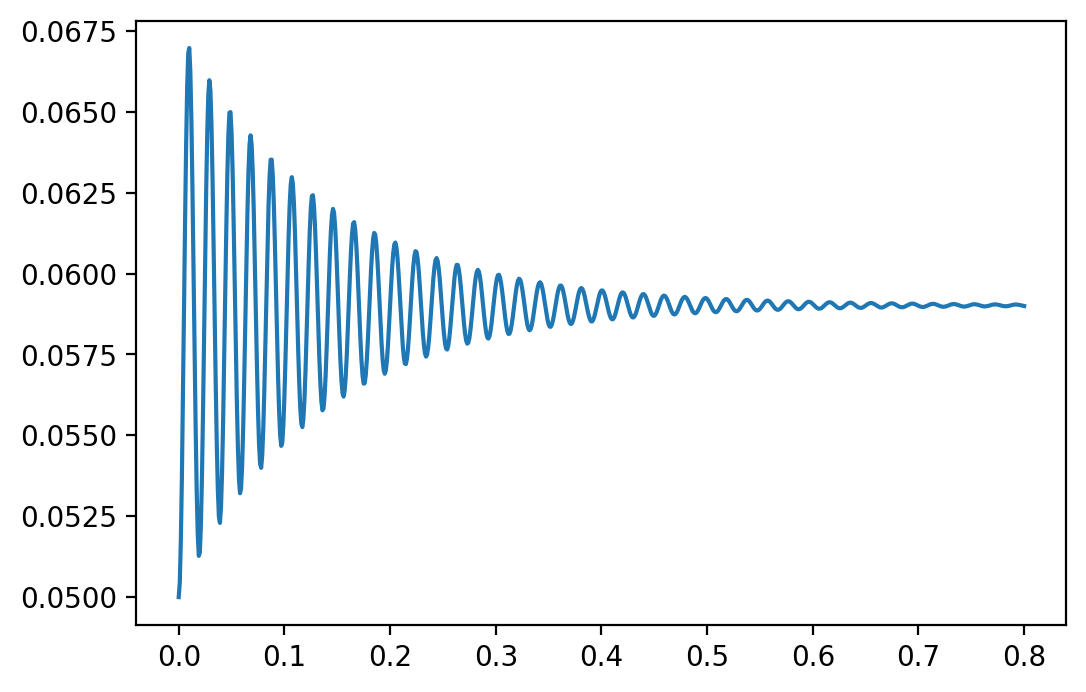

In [35]:
fig, ax = plt.subplots(dpi=200)
ax.plot(time,solution[:, 0]);
#ax.plot(tim, sol, '--');

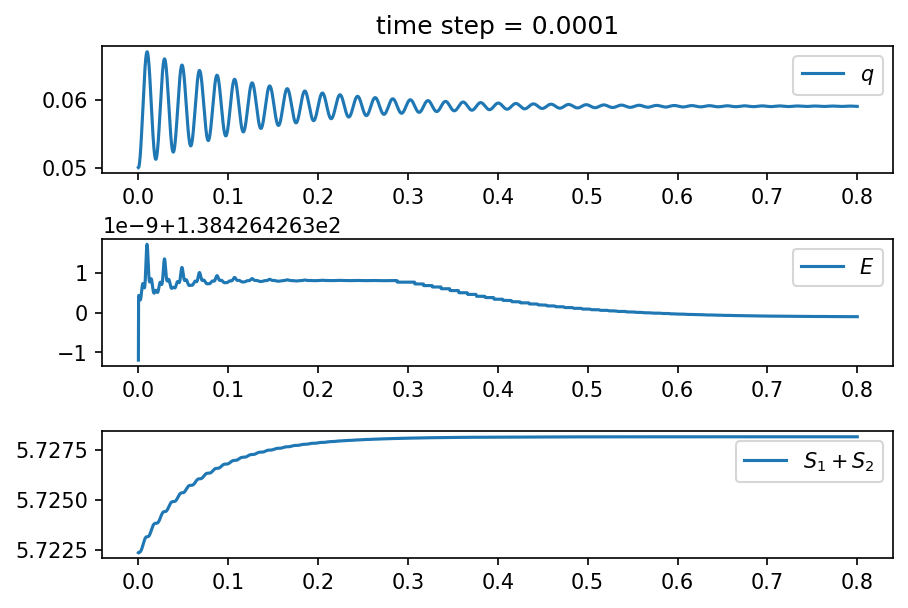

In [50]:
energy = evaluate_functional(x, E, solution, functionals, params)
entropy = evaluate_functional(x, S_1 + S_2, solution, functionals, params)

fig, axes = plt.subplots(nrows=3, dpi=150)
fig.tight_layout()
axes[0].set_title(f"time step = {dt}")
axes[0].plot(time, solution[:, 0], label="$q$")
axes[1].plot(time, energy, label="$E$")
axes[2].plot(time, entropy, label="$S_1 + S_2$")
for ax in axes:
    ax.legend();

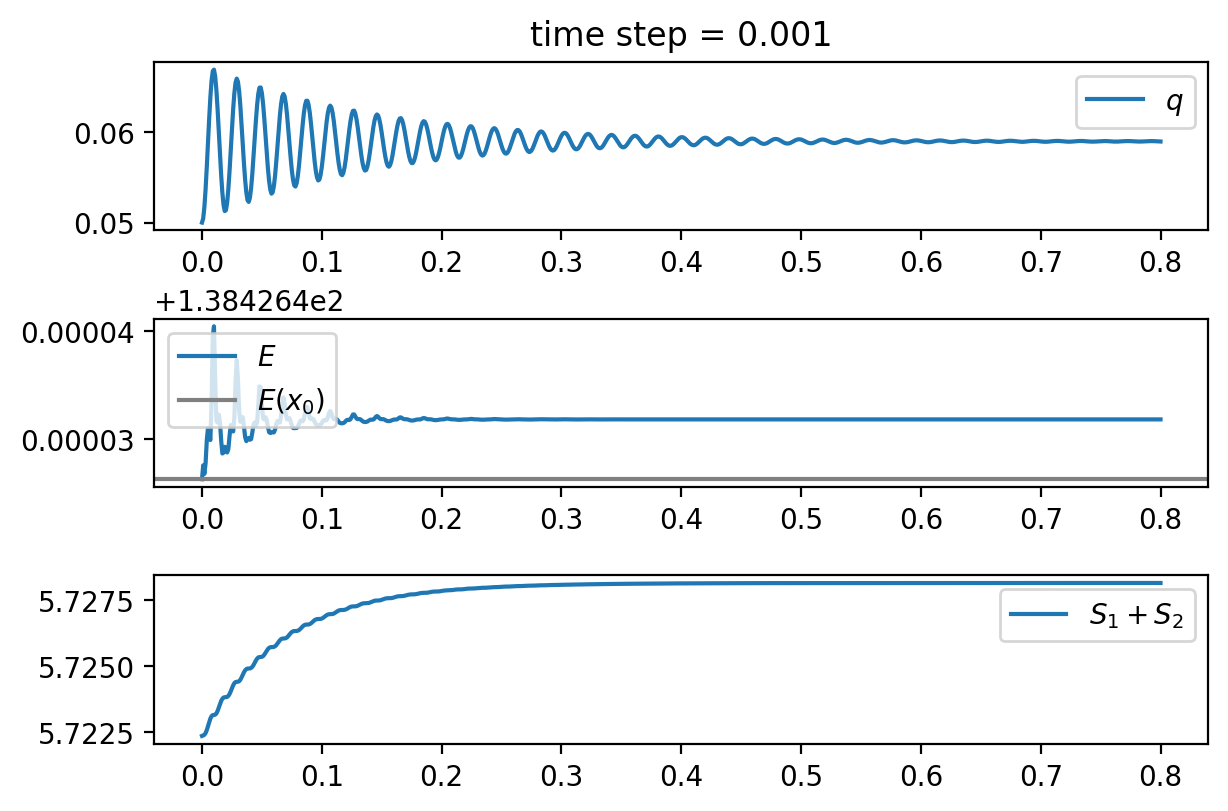

In [36]:
energy = evaluate_functional(x, E, solution, functionals, params)
E0 = float(eval_expr(E, functionals, params, (x, x_0)))
entropy = evaluate_functional(x, S_1 + S_2, solution, functionals, params)

fig, ax = plt.subplots(nrows=3, dpi=200)
fig.tight_layout()
ax[0].set_title(f"time step = {dt}")
ax[0].plot(time, solution[:, 0], label="$q$")
ax[1].plot(time, energy, label="$E$")
ax[1].axhline(E0, label="$E(x_0)$", c="gray")
ax[2].plot(time, entropy, label="$S_1 + S_2$")
ax[0].legend()
ax[1].legend()
ax[2].legend();

In [31]:
import matplotlib
import matplotlib.animation as anim

In [32]:
plt.ioff()

r2 = 2 * params[r]          # diameter of cylinder
w2 = params[w] / 2          # halved thickness of wall
l2 = params[l] - w2

cmap = matplotlib.cm.get_cmap('YlOrRd')

fig, ax = plt.subplots(dpi=100)
ax.set_xlim(left=0, right=params[l])
ax.set_ylim(bottom=-params[r], top=params[r])

q0 = params[l]/2
vol1 = plt.Rectangle((0, -params[r]), q0-w2, r2, fc='b')
ax.add_patch(vol1)
pist = plt.Rectangle((q0-w2, -params[r]), params[w], r2, fc='#C84843')
ax.add_patch(pist)
vol2 = plt.Rectangle((q0+w2, -params[r]), l2-q0, r2, fc='g')
ax.add_patch(vol2)

T_1sol = evaluate_functional(x, T_1, solution, functionals, params)
T_2sol = evaluate_functional(x, T_2, solution, functionals, params)
T_min = numpy.min([numpy.min(T_1sol), numpy.min(T_2sol)])
T_max = numpy.max([numpy.max(T_1sol), numpy.max(T_2sol)])
T_swing = T_max - T_min

data = numpy.block([solution, T_1sol.reshape(-1,1), T_2sol.reshape(-1,1)])

def animate(datum):
    qd = datum[0]
    T_1d = datum[4]
    T_2d = datum[5]
    
    l_1 = qd - w2
    l_2 = l2 - qd
    
    vol1.set_width(l_1)
    pist.set_x(l_1)
    vol2.set_x(l_1 + params[w])
    vol2.set_width(l_2)
    
    vol1.set_fc(cmap(0.8 * ((T_1d-T_min) / T_swing)))
    vol2.set_fc(cmap(0.8 * ((T_2d-T_min) / T_swing)))
    
    return (vol1, pist, vol2)

animation = anim.FuncAnimation(fig, animate, frames=data, blit=True, repeat=False)
animation.save('piston2.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
plt.close(fig)